In [1]:
# Imports

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizerFast, BertForQuestionAnswering
from tqdm import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re

/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
# Dataset Class

class QADataset(Dataset):
    def __init__(self, encoded_data):
        self.encoded_data = {key: torch.tensor(val) for key, val in encoded_data.items()}
    
    def __getitem__(self, index):
        return {key: val[index] for key, val in self.encoded_data.items()}
    
    def __len__(self):
        return len(self.encoded_data['input_ids'])

In [3]:
# Functions to calculate F1 score and Exact Match Score

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

def calculate_exact_match(pred, target):
    return float(clean_text(pred) == clean_text(target))

def calculate_f1_score(pred, target):
    pred_words = clean_text(pred).split()
    target_words = clean_text(target).split()
    
    if len(pred_words) == 0 or len(target_words) == 0:
        return 0.0
    
    pred_set = set(pred_words)
    target_set = set(target_words)
    
    common = len(pred_set & target_set)
    if common == 0:
        return 0.0
        
    prec = common / len(pred_set)
    rec = common / len(target_set)
    
    if prec + rec == 0:
        return 0.0
    f1 = 2.0 * prec * rec / (prec + rec)
    return f1

In [4]:
# Helper functions to read the json files, to fetch the data

def load_qa_data(filepath):
    with open(filepath, 'rb') as f:
        raw_data = json.load(f)
    
    passages, queries, responses = [], [], []
    for group in raw_data['data']:
        for paragraph in group['paragraphs']:
            passage = paragraph['context'].strip().lower()
            for qa_pair in paragraph['qas']:
                query = qa_pair['question'].strip().lower()
                for response in qa_pair['answers']:
                    passages.append(passage)
                    queries.append(query)
                    response['text'] = response['text'].lower().strip()
                    responses.append(response)
    return passages, queries, responses

In [5]:
def prepare_qa_data(passages, queries, responses, tokenizer, seq_length=512):
    passages = [p.strip() for p in passages]
    queries = [q.strip() for q in queries]
    
    tokenized_data = tokenizer(queries, passages, 
                         max_length=seq_length,
                         truncation=True, 
                         padding=True, 
                         return_offsets_mapping=True,
                         return_token_type_ids=True)
    
    answer_starts, answer_ends = [], []
    token_positions = tokenized_data.pop('offset_mapping')
    
    for idx, (positions, passage) in enumerate(zip(token_positions, passages)):
        response_text = responses[idx]['text']
        text_start = responses[idx]['answer_start']
        text_end = text_start + len(response_text)
        
        sequence_markers = tokenized_data.sequence_ids(idx)
        passage_start = sequence_markers.index(1)
        passage_end = len(sequence_markers) - sequence_markers[::-1].index(1)
        
        if positions[passage_start][0] > text_end or positions[passage_end - 1][1] < text_start:
            answer_starts.append(0)
            answer_ends.append(0)
            continue
            
        idx_pos = passage_start
        while idx_pos < passage_end and positions[idx_pos][0] <= text_start:
            idx_pos += 1
        answer_starts.append(idx_pos - 1)
        
        idx_pos = passage_end - 1
        while idx_pos >= passage_start and positions[idx_pos][1] >= text_end:
            idx_pos -= 1
        answer_ends.append(idx_pos + 1)
    
    tokenized_data['start_positions'] = answer_starts
    tokenized_data['end_positions'] = answer_ends
    return tokenized_data

In [6]:
# Function used to train the model

def train_qa_model(qa_model, data_loader, device, max_epochs=3, learning_rate=2e-5):
    qa_model.to(device)
    optimizer = AdamW(qa_model.parameters(), lr=learning_rate, weight_decay=0.01)
    
    training_stats = {'loss': [], 'accuracy': []}
    
    for epoch in range(max_epochs):
        qa_model.train()
        epoch_losses = []
        epoch_accuracies = []
        
        with tqdm(data_loader, desc=f'Epoch {epoch + 1}/{max_epochs}') as progress_bar:
            for batch_data in progress_bar:
                optimizer.zero_grad()
                
                input_ids = batch_data['input_ids'].to(device)
                attention_mask = batch_data['attention_mask'].to(device)
                start_pos = batch_data['start_positions'].to(device)
                end_pos = batch_data['end_positions'].to(device)
                
                model_output = qa_model(input_ids, 
                              attention_mask=attention_mask,
                              start_positions=start_pos,
                              end_positions=end_pos)
                
                batch_loss = model_output.loss
                batch_loss.backward()
                optimizer.step()
                
                pred_starts = model_output.start_logits.argmax(dim=1)
                pred_ends = model_output.end_logits.argmax(dim=1)
                batch_accuracy = ((pred_starts == start_pos).float().mean() + 
                          (pred_ends == end_pos).float().mean()) / 2
                
                epoch_losses.append(batch_loss.item())
                epoch_accuracies.append(batch_accuracy.item())
                
                progress_bar.set_postfix({'loss': f'{batch_loss.item():.4f}', 
                                'accuracy': f'{batch_accuracy.item():.4f}'})
        
        avg_epoch_loss = np.mean(epoch_losses)
        avg_epoch_accuracy = np.mean(epoch_accuracies)
        training_stats['loss'].append(avg_epoch_loss)
        training_stats['accuracy'].append(avg_epoch_accuracy)
        
        print(f'Epoch {epoch + 1} - Avg Loss: {avg_epoch_loss:.4f}, Avg Accuracy: {avg_epoch_accuracy:.4f}')
    
    return training_stats

In [7]:
# Evaluating the model

def evaluate_qa_model(qa_model, eval_loader, tokenizer, device):
    qa_model.eval()
    f1_scores = []
    em_scores = []
    
    with torch.no_grad():
        for batch_data in tqdm(eval_loader, desc='Evaluating'):
            input_ids = batch_data['input_ids'].to(device)
            attention_mask = batch_data['attention_mask'].to(device)
            
            model_output = qa_model(input_ids, attention_mask=attention_mask)
            
            start_logits = model_output.start_logits
            end_logits = model_output.end_logits
            
            for i in range(len(input_ids)):
                pred_start = torch.argmax(start_logits[i]).item()
                pred_end = torch.argmax(end_logits[i]).item()
                
                if pred_end < pred_start:
                    pred_end = pred_start
                
                if pred_end - pred_start > 30:
                    pred_end = pred_start + 30
                
                predicted_tokens = input_ids[i][pred_start:pred_end + 1]
                target_tokens = input_ids[i][batch_data['start_positions'][i]:batch_data['end_positions'][i] + 1]
                
                predicted_answer = tokenizer.decode(predicted_tokens, skip_special_tokens=True)
                target_answer = tokenizer.decode(target_tokens, skip_special_tokens=True)
                
                if not predicted_answer.strip() or not target_answer.strip():
                    continue
                
                f1 = calculate_f1_score(predicted_answer, target_answer)
                em = calculate_exact_match(predicted_answer, target_answer)
                
                f1_scores.append(f1)
                em_scores.append(em)
    
    if not f1_scores:
        return {'f1': 0.0, 'exact_match': 0.0}
    
    return {
        'f1': np.mean(f1_scores) * 100,
        'exact_match': np.mean(em_scores) * 100
    }

In [8]:
def plot_training_metrics(metrics):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(metrics['loss'])
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(metrics['accuracy'])
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    plt.tight_layout()
    plt.savefig('training_metrics_simple_bert.png')
    plt.show()
    plt.close()

Using device: cuda


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading training data...
Starting training...


Epoch 1/3: 100%|██████████| 2320/2320 [17:40<00:00,  2.19it/s, loss=2.0507, accuracy=0.4286]


Epoch 1 - Avg Loss: 1.9114, Avg Accuracy: 0.4938


Epoch 2/3: 100%|██████████| 2320/2320 [17:41<00:00,  2.19it/s, loss=0.5481, accuracy=0.8571]


Epoch 2 - Avg Loss: 1.0710, Avg Accuracy: 0.6800


Epoch 3/3: 100%|██████████| 2320/2320 [17:41<00:00,  2.19it/s, loss=0.5207, accuracy=0.9286]


Epoch 3 - Avg Loss: 0.7006, Avg Accuracy: 0.7768


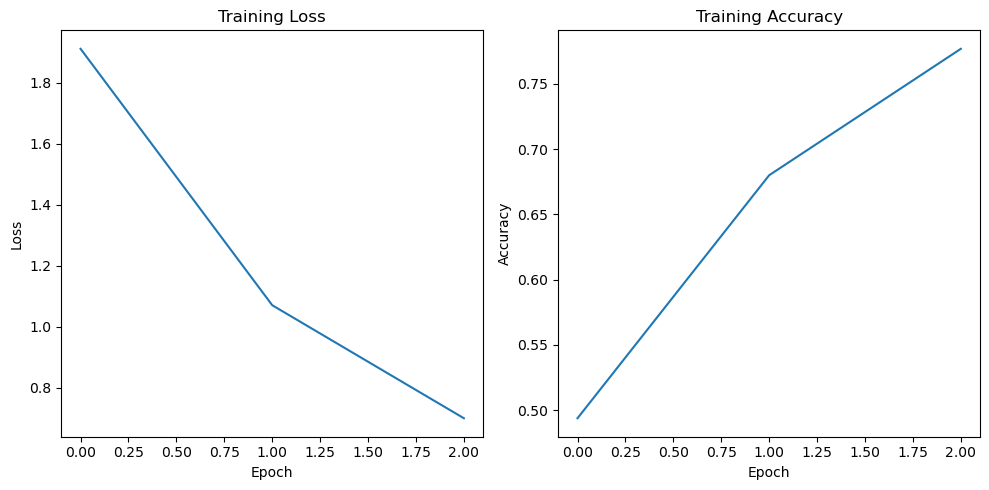


Evaluating on No Noise test set...


Evaluating: 100%|██████████| 993/993 [02:33<00:00,  6.47it/s]


Results for No Noise:
F1 Score: 66.69%
EM Score: 48.36%

Evaluating on WER 44 test set...


Evaluating: 100%|██████████| 1116/1116 [02:52<00:00,  6.46it/s]


Results for WER 44:
F1 Score: 25.87%
EM Score: 4.77%

Evaluating on WER 54 test set...


Evaluating: 100%|██████████| 1116/1116 [02:52<00:00,  6.46it/s]

Results for WER 54:
F1 Score: 20.91%
EM Score: 2.88%


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

MODEL_TYPE = 'bert-base-uncased'
MAX_SEQ_LENGTH = 512
BATCH_SIZE = 16
NUM_EPOCHS = 3
LR = 2e-5

tokenizer = BertTokenizerFast.from_pretrained(MODEL_TYPE)
qa_model = BertForQuestionAnswering.from_pretrained(MODEL_TYPE)

# Load and process training data
print("Loading training data...")
train_passages, train_queries, train_responses = load_qa_data('spoken_train-v1.1.json')
train_encoded = prepare_qa_data(train_passages, train_queries, train_responses, tokenizer)
train_dataset = QADataset(train_encoded)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Train the model
print("Starting training...")
training_metrics = train_qa_model(qa_model, train_loader, device, NUM_EPOCHS, LR)
plot_training_metrics(training_metrics)

# Evaluate on test sets
test_files = [
    ('No Noise', 'spoken_test-v1.1.json'),
    ('WER 44', 'spoken_test-v1.1_WER44.json'),
    ('WER 54', 'spoken_test-v1.1_WER54.json')
]

# Saving results
with open('qa_evaluation_results_bert.txt', 'w') as f:
    f.write("Question Answering Evaluation Results\n")
    f.write("===================================\n\n")
    
    for test_name, test_file in test_files:
        print(f"\nEvaluating on {test_name} test set...")
        test_passages, test_queries, test_responses = load_qa_data(test_file)
        test_encoded = prepare_qa_data(test_passages, test_queries, test_responses, tokenizer)
        test_dataset = QADataset(test_encoded)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
        
        results = evaluate_qa_model(qa_model, test_loader, tokenizer, device)
        
        # Print to console
        print(f"Results for {test_name}:")
        print(f"F1 Score: {results['f1']:.2f}%")
        print(f"EM Score: {results['exact_match']:.2f}%")
        
        # Write to file
        f.write(f"Results for {test_name}:\n")
        f.write(f"F1 Score: {results['f1']:.2f}%\n")
        f.write(f"EM Score: {results['exact_match']:.2f}%\n\n")
    
    f.write("===================================\n")
    f.write("Evaluation completed successfully.\n")